In [1]:
! pip install attrdict
import torch
import torch.nn as nn
import random
import math
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
import torch
import torch.nn as nn


class Emitter(nn.Module):
    def __init__(self, z_dim, hidden_dim, obs_dim):
        super(Emitter, self).__init__()
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim)
        self.hidden_to_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_to_loc = nn.Linear(hidden_dim, obs_dim)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, z):
        hidden1 = self.relu(self.z_to_hidden(z))
        hidden2 = self.relu(self.hidden_to_hidden(hidden1))
        loc = self.hidden_to_loc(hidden2)

        return loc


class Transition(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Transition, self).__init__()
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim)
        self.hidden_to_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_to_loc = nn.Linear(hidden_dim, z_dim)
        self.hidden_to_sig = nn.Linear(hidden_dim, z_dim)

        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, z_t_1):

        hidden1 = self.relu(self.z_to_hidden(z_t_1))
        hidden2 = self.relu(self.hidden_to_hidden(hidden1))

        loc = self.hidden_to_loc(hidden2) + z_t_1
        sigma = self.softplus(self.hidden_to_sig(hidden2))

        return loc, sigma


class Posterior(nn.Module):
    def __init__(self, z_dim, hidden_dim, obs_dim):
        super(Posterior, self).__init__()
        self.z_obs_to_hidden = nn.Linear(2*z_dim + obs_dim, hidden_dim)
        self.hidden_to_hidden = nn.Linear(hidden_dim, hidden_dim)

        self.hidden_to_loc = nn.Linear(hidden_dim, z_dim)
        self.hidden_to_sig = nn.Linear(hidden_dim, z_dim)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, z_mu, z_sig, obs_t):
        hidden1 = self.relu(self.z_obs_to_hidden(torch.cat((z_mu, z_sig, obs_t), dim=-1)))
        hidden2 = self.relu(self.hidden_to_hidden(hidden1))

        loc = self.hidden_to_loc(hidden2)
        sig = self.softplus(self.hidden_to_sig(hidden2))

        return loc, sig


class DeepKalmanFilter(nn.Module):
    def __init__(self, config):
        super(DeepKalmanFilter, self).__init__()

        self.emitter = Emitter(config.z_dim, config.emit_hidden_dim, config.obs_dim)
        self.transition = Transition(config.z_dim, config.trans_hidden_dim)

        self.posterior = Posterior(
            config.z_dim,
            config.post_hidden_dim,
            config.obs_dim
        )

        self.z_q_0 = nn.Parameter(torch.zeros(config.z_dim))
        self.emit_log_var = nn.Parameter(-5. * torch.ones(config.obs_dim))

        self.config = config

    @staticmethod
    def reparametrization(mu, sig):
        return mu + torch.randn_like(sig) * sig

    @staticmethod
    def kl_div(mu0, sig0, mu1, sig1):
        return -0.5 * torch.sum(1 - 2 * sig1.log() + 2 * sig0.log()
                                - (mu1 - mu0).pow(2) / sig1.pow(2) - (sig0/sig1).pow(2))
    
    @staticmethod
    def reconstruction_loss(data, mu, var, log_var):
      sum_dim = [i for i in range(data.ndim-1)]
      element_num =  data.numel() / data.shape[-1]
      return ((data - mu).pow(2).sum(dim=sum_dim) / 2 / var
                                + (log_var/2+1/2*math.log(2*math.pi)) * element_num).sum()


    def loss(self, obs):

        time_step = obs.size(1)
        batch_size = obs.size(0)
        overshoot_len = self.config.overshooting

        kl = torch.Tensor([0]).to(self.config.device)
        reconstruction = torch.Tensor([0]).to(self.config.device)

        emit_var = self.emit_log_var.exp()

        z_q_t_1 = self.z_q_0.expand((self.config.sampling_num, batch_size, self.config.z_dim))
        obs = obs.expand((self.config.sampling_num, ) + obs.shape)
        
        for t in range(time_step):
            trans_loc, trans_sig = self.transition(z_q_t_1)
            
            post_loc, post_sig = self.posterior(trans_loc, trans_sig, obs[:, :, t])

            z_q_t = self.reparametrization(post_loc, post_sig)      
            emit_loc = self.emitter(z_q_t)

            reconstruction += self.reconstruction_loss(obs[:, :, t], emit_loc, emit_var, self.emit_log_var)

            kl = kl + self.kl_div(post_loc, 
                      post_sig, 
                      trans_loc, trans_sig) / min(t+1, overshoot_len)
            

            # if overshoot_len > 1:
            #   if t > 0:
            #     over_loc, over_sig = self.transition(overshooting[:overshoot_len-1].detach())
            #     kl = kl + self.kl_div(post_loc.detach(),
            #           post_sig.detach(), 
            #           over_loc, over_sig) / min(t+1, overshoot_len)
            #     over_loc = torch.cat([trans_loc.unsqueeze(0), over_loc], dim=0)
            #     over_sig = torch.cat([trans_sig.unsqueeze(0), over_sig], dim=0)
            #   else:
            #     over_loc = trans_loc.unsqueeze(0)
            #     over_sig = trans_sig.unsqueeze(0)

            #   overshooting = self.reparametrization(over_loc, over_sig)

            z_q_t_1 = z_q_t

              

        reconstruction = reconstruction / self.config.sampling_num
        kl = kl / self.config.sampling_num
        return reconstruction, kl


def predict(seq, model, step=20, num_particles=1):
    predicted = torch.empty((num_particles, len(seq), step, model.config.obs_dim))
    z_data = []
    z_pred = []
    with torch.no_grad():
        z_q_t_1 = model.z_q_0.expand((seq.shape[0], model.config.z_dim))
        for s in range(seq.shape[1]):
            prior_mu, prior_sig = model.transition(z_q_t_1)
            z_q_t, _ = model.posterior(prior_mu, prior_sig, seq[:, s])
            z_q_t_1 = z_q_t
            z_data.append(z_q_t)
        
        z_q_t_1 = z_q_t_1.expand((num_particles, *z_q_t_1.shape))

        for s in range(step):
            z_q_t_loc, z_q_t_sig = model.transition(z_q_t_1)
            z_q_t = model.reparametrization(z_q_t_loc, z_q_t_sig)
            predicted[:, :, s] = model.emitter(z_q_t)
            z_q_t_1 = z_q_t
            z_pred.append(z_q_t)

    return predicted, torch.stack(z_data), torch.stack(z_pred)


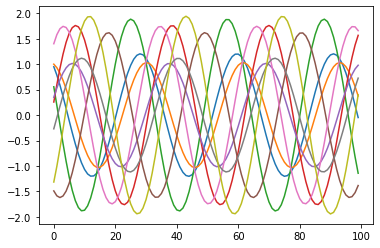

torch.Size([100, 100])
torch.Size([100, 100, 1])


In [3]:

import torch
from torch import optim

import matplotlib.pyplot as plt
import numpy as np
from attrdict import AttrDict
import tqdm

%load_ext autoreload
%autoreload 2

batch_size = 100
time_step = 100

data = []

def gen_data():
    r = np.random.rand() + 1
    theta = np.random.rand() * 2 * np.pi
    v = np.random.rand()* 2 + 4
    return [r*np.sin(t/5+theta) for t in range(time_step)]

for _ in range(batch_size):
    data.append(gen_data())

data = torch.Tensor(data)

valid_data = []

for _ in range(batch_size):
    valid_data.append(gen_data())

valid_data = torch.Tensor(valid_data)


for i in range(9):
    plt.plot(data[10*i])
plt.show()


config = AttrDict({"z_dim":2,
                   "emit_hidden_dim":50,
                   "trans_hidden_dim":50,
                   "post_hidden_dim":50,
                   "obs_dim":1,
                   "sampling_num":5,
                   "device": device,
                   "overshooting" : 1
                   })
dkf = DeepKalmanFilter(config)

optimizer = optim.Adam(dkf.parameters(), lr=0.001)
dkf.train()



print(data.shape)
print(data.unsqueeze(-1).shape)


valid_losses = []

In [4]:
def beta_annealing(step, start=100, end=4000):
  return 1
  # if step < start:
  #     return 0.1
  # elif step > end:
  #     return 1.1
  # else:
  #     return 0.1 + (step - start) / (end - start)

iter_num = 6000
data = data.to(device)
valid_data = valid_data.to(device)
dkf = dkf.to(device)
with tqdm.tqdm(range(iter_num)) as pbar:
    for i in pbar:
        optimizer.zero_grad()
        reconstruction, kl = dkf.loss(data.unsqueeze(-1))
        loss = reconstruction + beta_annealing(i) * kl
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            valid_reconstruction, valid_kl = dkf.loss(valid_data.unsqueeze(-1))
        valid_loss = valid_reconstruction + beta_annealing(i) * valid_kl
        valid_losses.append(valid_loss)
        pbar.set_postfix_str("[train kl %d, reconstruction %d, valid_kl %d, valid_reconst %d]"
                            % (kl, reconstruction, valid_kl, valid_reconstruction))


 52%|█████▏    | 3121/6000 [21:19<19:40,  2.44it/s, [train kl 4373, reconstruction -15151, valid_kl 4530, valid_reconst -15152]]


KeyboardInterrupt: ignored

Parameter containing:
tensor([-5.1314], requires_grad=True)


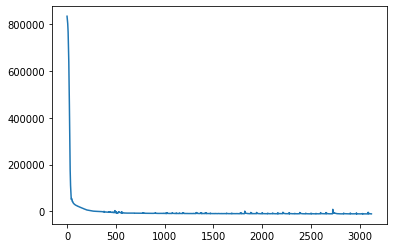

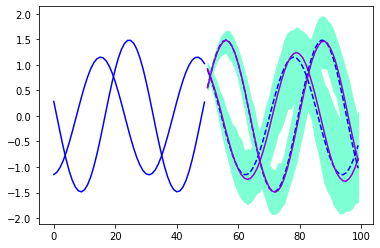

In [5]:

plt.plot(torch.stack(valid_losses).squeeze())
print(dkf.emit_log_var)
plt.show()


#%%


test_data = []

for _ in range(batch_size):
    test_data.append(gen_data())

test_data = torch.Tensor(test_data).to(device)

pred_ind = [np.random.randint(0, 100) for _ in range(2)]
predicted, z_data, z_pred = predict(test_data[pred_ind, :50].unsqueeze(-1), dkf, step=50, num_particles=100)

#%%
test_data = test_data.cpu()
predicted = predicted.cpu()

%matplotlib inline
def plot_predicted(ax, data, predicted, c="blue", pred_c="darkviolet", fill_c="aquamarine"):
    pred_len = predicted.shape[1]
    data_len = len(data)

    ax.plot(np.arange(data_len - pred_len), data[:data_len - pred_len], c=c)
    pred_x = np.arange(data_len - pred_len, len(data))
    
    percentile = torch.quantile(predicted, torch.tensor([0.05, 0.95]), dim=0).squeeze()
    ax.fill_between(pred_x, percentile[0], percentile[1], color=fill_c)
    ax.plot(pred_x, data[data_len - pred_len:], linestyle='dashed', c=c)
    ax.plot(pred_x, predicted.mean(dim=0), c=pred_c)


    return ax

fig = plt.figure()
ax = fig.add_subplot()
for i, ind in enumerate(pred_ind):
    ax = plot_predicted(ax, test_data[ind], predicted[:, i])
fig.show()


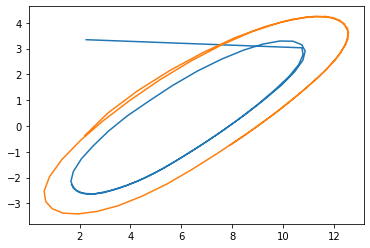

In [8]:
z = z_data.cpu()
plt.plot(z[:, :, 0], z[:, :, 1])